In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
from scipy.io import wavfile

# Lire un fichier .wav
sample_rate, data_original = wavfile.read("./voice_origin/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_1_.wav")

print(f"Taux d'échantillonnage : {sample_rate} Hz")
print(f"Shape des données : {data_original.shape}")


Taux d'échantillonnage : 4000 Hz
Shape des données : (40000,)


In [3]:
sample_rate, data_loss = wavfile.read("./packet_loss/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_1_.wav")

print(f"Taux d'échantillonnage : {sample_rate} Hz")
print(f"Shape des données : {data_loss.shape}")

Taux d'échantillonnage : 8000 Hz
Shape des données : (80000,)


In [4]:
data_orig_norm = (np.max(data_loss) / np.max(data_original) )*  data_original  # Normalisation des données 

In [5]:
data_hole = data_loss[::2]

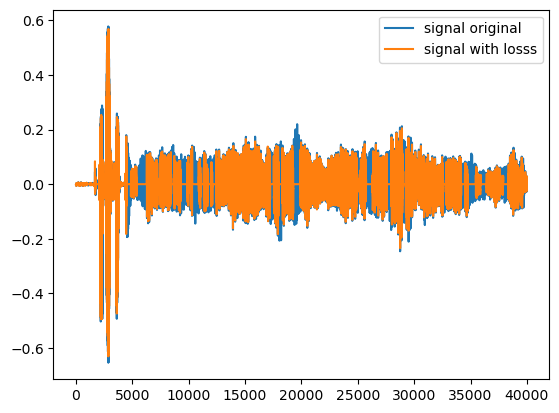

In [6]:
plt.figure()
plt.plot(np.arange(len(data_orig_norm)),data_orig_norm,label = 'signal original')
plt.plot(np.arange(len(data_orig_norm)),data_hole,label='signal with losss')
plt.legend()

In [7]:
threshold = 0.05  # Définir un seuil pour détecter les zones où l'on a enlevé la voie
difference = np.abs(data_orig_norm- data_hole)
modified_mask = difference > threshold  # Masque pour indiquer ces zones


In [8]:
argloss = []
epsilon = 0.04
for i in range(len(data_orig_norm)):
    if np.abs((data_loss[2*i]-data_orig_norm[i]))>epsilon:
        argloss.append(i)

# Modèle ARIMA 

In [21]:
from statsmodels.tsa.arima.model import ARIMA

def train_arima(signal, order=(1, 0, 0)):
    model = ARIMA(signal, order=order)
    fit = model.fit()
    return fit

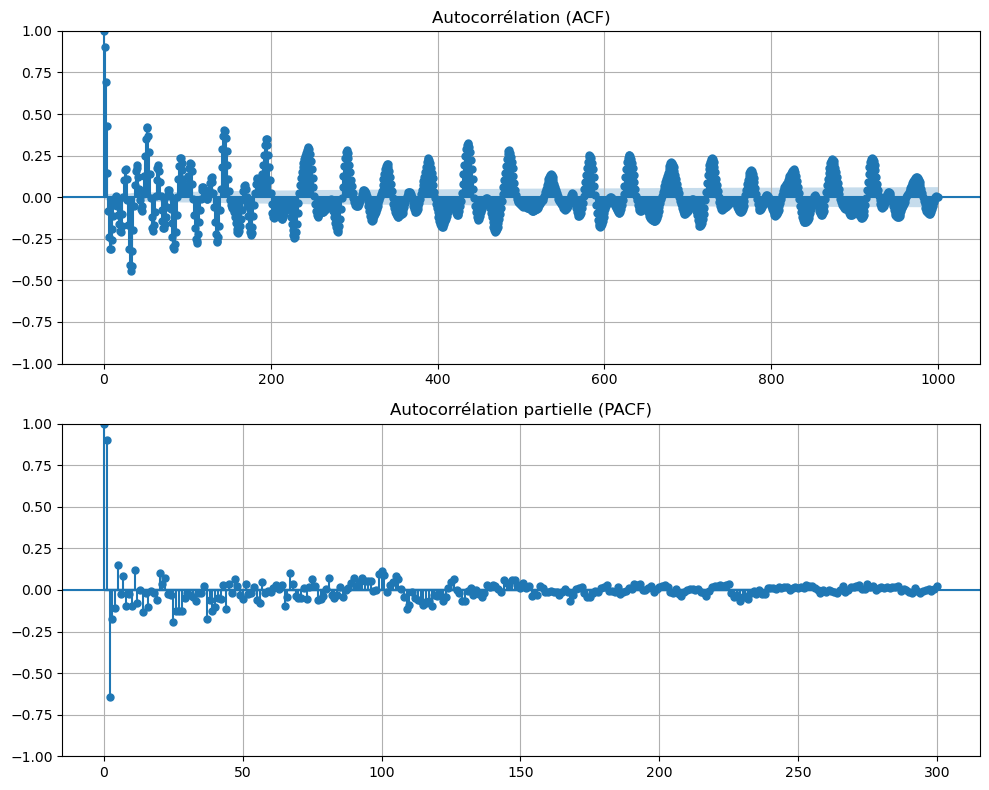

In [22]:

# Tracer l'autocorrélation et l'autocorrélation partielle
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data_orig_norm, lags= 1000, ax=axes[0], title="Autocorrélation (ACF)")
axes[0].grid()

# PACF
plot_pacf(data_orig_norm, lags=300, ax=axes[1], method='ywm', title="Autocorrélation partielle (PACF)")
axes[1].grid()

plt.tight_layout()
plt.show()

In [88]:
arima_model = train_arima(data_orig_norm,order = (20,0,20))

/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
def reconstruct_signal_with_arima(signal, mask, arima_model):
    reconstructed_signal = signal.copy()
    for i in range(len(mask)):
        if mask[i]:
            try:
                prediction = arima_model.forecast(steps=1)
                reconstructed_signal[i] = prediction[0]
            except Exception as e:
                print(f"Erreur lors de la prédiction ARIMA à l'indice {i}: {e}")
    return reconstructed_signal

In [49]:
from tqdm import tqdm
def reconstruct_signal_with_arima(signal, mask, arima_model):
    reconstructed_signal = signal.copy()
    i=0
    with tqdm(total=len(mask), desc="Reconstruction du signal") as pbar:
        while i < len(mask):
            if mask[i]:
                step = 1
                j=i+1
                while j< len(mask) and mask[j]:
                    j+=1
                    step+=1
                try:
                    prediction = arima_model.forecast(steps=step)
                    
                    reconstructed_signal[i:j] = prediction[:step]
                    if j-i == 1:
                        arima_model.append([prediction[0]],refit=False)
                    else:
                        arima_model.append(prediction[:step],refit=False)
                except Exception as e:
                    print(f"Erreur lors de la prédiction ARIMA à l'indice {i}: {e}")
                i=j
                pbar.update(j-i)
            else:
                arima_model.append([reconstructed_signal[i]],refit=False)
                i+=1
                pbar.update(1)
    return reconstructed_signal

In [92]:
from tqdm import tqdm
def reconstruct_signal_with_arima(signal, mask, arima_model):
    arima_coeffs = {
        'ar': arima_model.arparams,  # Coefficients AR
        'ma': arima_model.maparams,  # Coefficients MA
        #'d': arima_model.d,          # Ordre de différenciation
        'order': arima_model.model.order  # Ordre du modèle (p, d, q)
    }
    reconstructed_signal = signal.copy()
    i=0
    with tqdm(total=len(mask), desc="Reconstruction du signal") as pbar:
        while i < len(mask):
            if mask[i]:
                step = 1
                j=i+1
                while j< len(mask) and mask[j]:
                    j+=1
                    step+=1
                try:
                    start_idx = max(0, i - len(arima_coeffs['ar']))
                    new_model = ARIMA(reconstructed_signal[start_idx:i], order=arima_coeffs['order']).fit()

                    # Appliquer les coefficients extraits (pas d'entraînement)

                    # Injecter les coefficients manuellement
                    new_model.arparams = arima_coeffs['ar']
                    new_model.maparams = arima_coeffs['ma']

                    prediction = new_model.forecast(steps=step)
                    
                    reconstructed_signal[i:j] = prediction[:step]
                   
                except Exception as e:
                    print(f"Erreur lors de la prédiction ARIMA à l'indice {i}: {e}")
                i=j
                pbar.update(j-i)
            else:
                i+=1
                pbar.update(1)
    return reconstructed_signal

In [93]:
reconstructed_signal = reconstruct_signal_with_arima(data_hole, modified_mask, arima_model)

Reconstruction du signal:   0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Reconstruction du signal:   5%|▌         | 2047/40000 [00:01<00:25, 1509.56it/s]/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packag

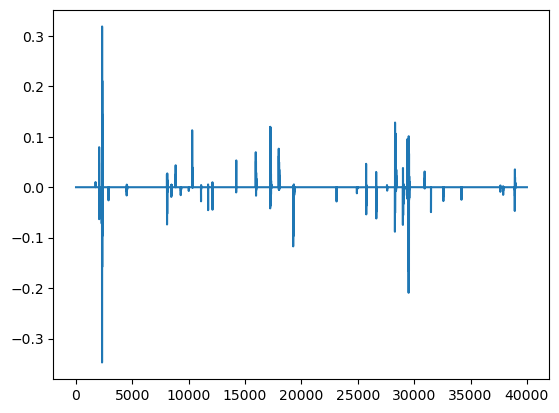

In [94]:
plt.plot(reconstructed_signal-data_hole)

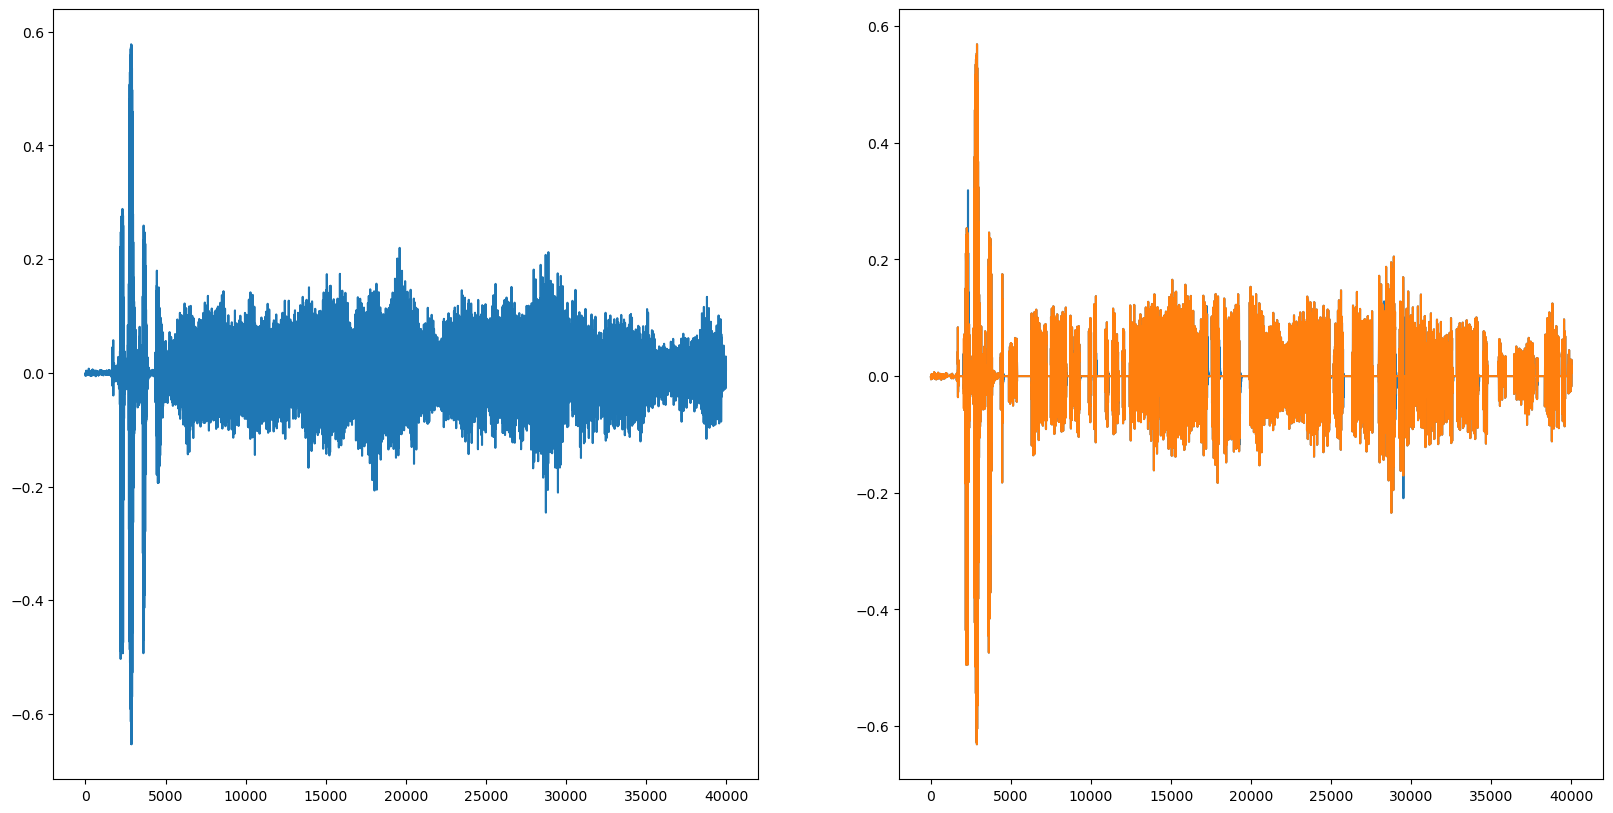

In [95]:
fig,ax  = plt.subplots(figsize= (20,10),nrows = 1,ncols = 2)

ax[0].plot(data_orig_norm)
ax[1].plot(reconstructed_signal)
ax[1].plot(data_hole)

In [96]:
print('Ecart au signal prédiction ARIMA ' + str(np.sum((reconstructed_signal-data_orig_norm)**2)))
print('Ecart au signal troué ' + str(np.sum((data_hole-data_orig_norm)**2)))

Ecart au signal prédiction ARIMA 31.658413
Ecart au signal troué 29.796642


# Interpolation

In [107]:
def linear_interpolation(signal, mask):
    """
    Remplace les trous dans le signal par interpolation linéaire.
    """
    # Identifie les indices des valeurs manquantes
    missing_indices = np.where(mask == 1)[0]

    # Identifie les indices des valeurs présentes
    valid_indices = np.where(mask == 0)[0]

    # Interpolation linéaire
    interpolated_signal = signal.copy()
    for idx in missing_indices:
        # Trouve les voisins valides
        #left = max(valid_indices[valid_indices < idx])  # Neighbour on the left
        left = idx-1
        right = min(valid_indices[valid_indices > idx])  # Neighbour on the right
        interpolated_signal[idx] = np.interp(idx, [left, right], [interpolated_signal[left], signal[right]])
    
    return interpolated_signal

In [108]:
reconstructed_signal_interp = linear_interpolation(data_hole,modified_mask)

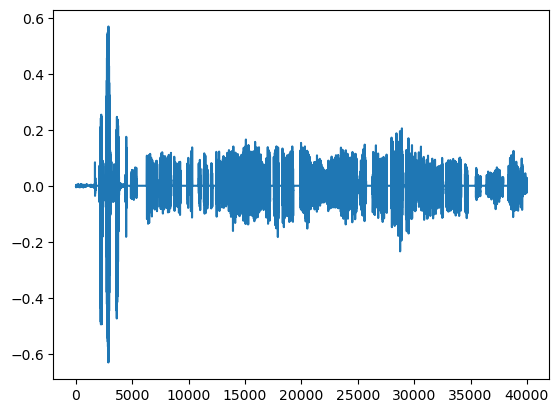

In [111]:
plt.plot(reconstructed_signal_interp)

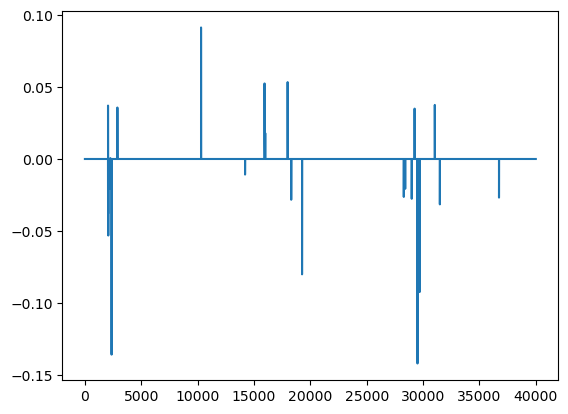

In [109]:
plt.plot(reconstructed_signal_interp-data_hole)

In [112]:
print('MSE interpolation ' + str(np.sum((reconstructed_signal_interp-data_orig_norm)**2)))
print('MSE signal troué ' + str(np.sum((data_hole-data_orig_norm)**2)))

MSE interpolation 29.350739
MSE signal troué 29.796642


# Unet

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = self.encoder_block(1, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)
        
        # Decoder
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        self.dec1 = nn.ConvTranspose1d(64, 1, kernel_size=2, stride=2)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Decoder
        dec4 = self.dec4(enc4)
        dec3 = self.dec3(dec4 + enc3)
        dec2 = self.dec2(dec3 + enc2)
        dec1 = self.dec1(dec2 + enc1)

        return dec1

# Entraînement du modèle
def train_unet_model(model, train_data, train_labels, epochs=10):
    criterion = nn.MSELoss()  # Fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")



In [21]:
import os
from scipy.io import wavfile

def load_audio_files_scipy(directory):
    audio_files = []
    filenames = []
    
    # Parcourir tous les fichiers du dossier
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            
            try:
                # Charger le fichier audio avec scipy
                sr, signal = wavfile.read(file_path)  # sr est la fréquence d'échantillonnage
                
                audio_files.append(signal)
                filenames.append(filename)
            except Exception as e:
                print(f"Erreur lors du chargement de {filename}: {e}")
    
    return audio_files, filenames

# Exemple d'utilisation
directory = "./packet_loss/train/"
signals_train, audio_filenames = load_audio_files_scipy(directory)
directory = "./voice_origin/train/"
signals_train_label = []
for filename in audio_filenames:
    file_path = os.path.join(directory,filename)
    sr, signal = wavfile.read(file_path)
    signals_train_label.append(signal)



In [22]:
for i in range(len(signals_train_label)):
    signals_train_label[i] = np.max(signals_train[i])/np.max(signals_train_label[i]) * signals_train_label[i]

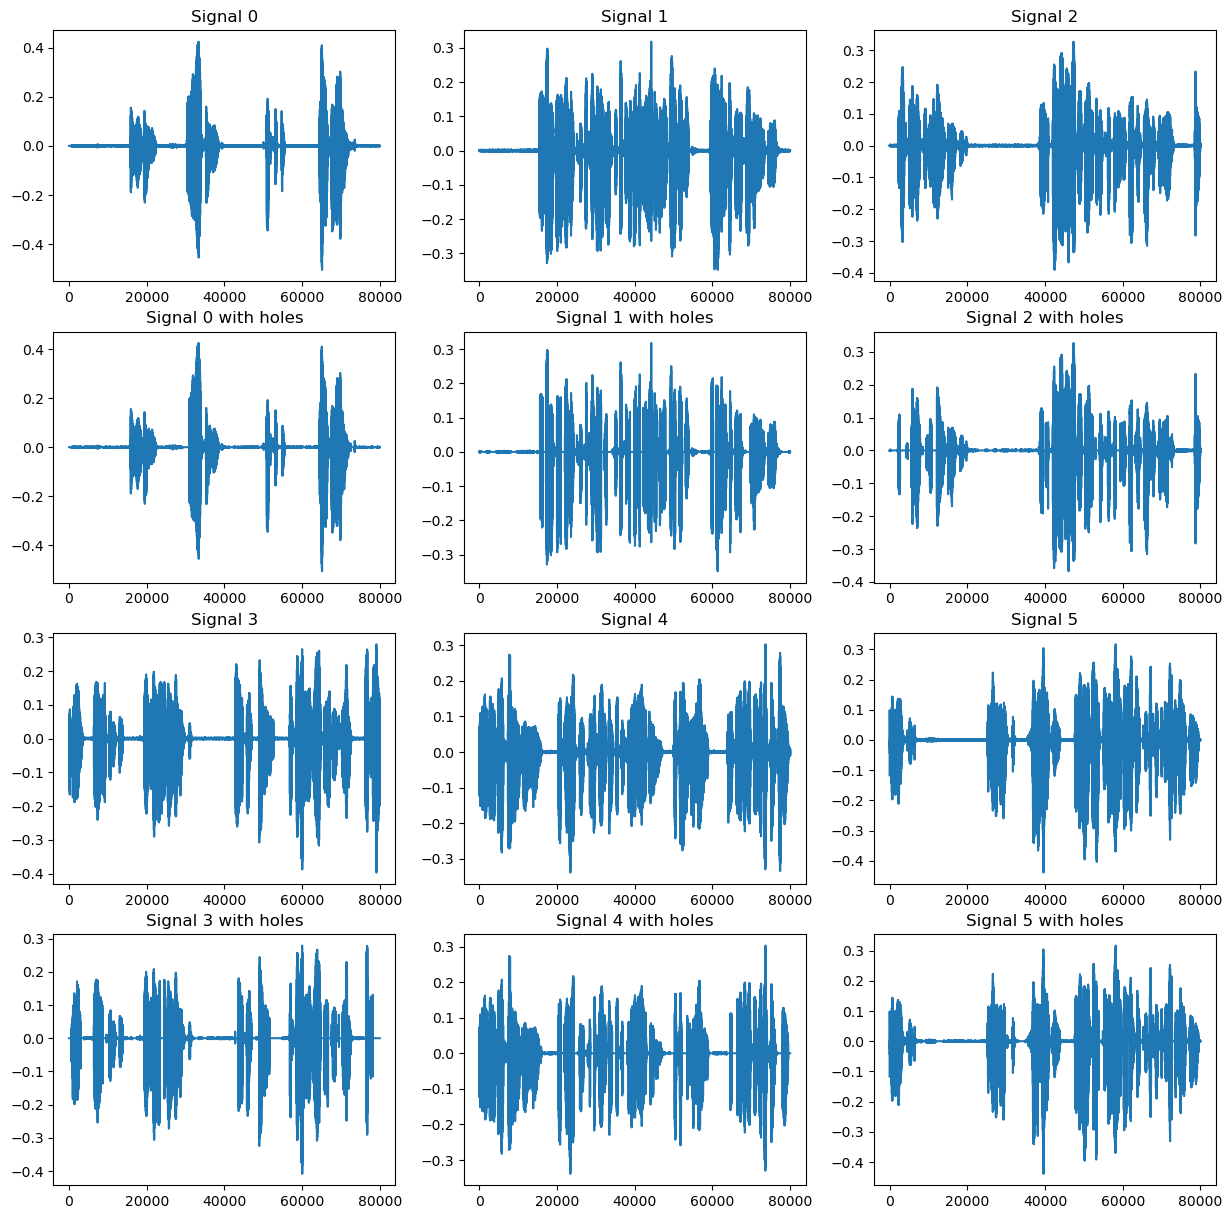

In [23]:
fig,ax = plt.subplots(figsize = (15,15),nrows = 4,ncols = 3)
for i in range(6):
    ax[2*(i//3),i%3].plot(signals_train_label[i])
    ax[2*(i//3)+1,i%3].plot(signals_train[i])
    ax[2*(i//3)+1,i%3].set_title(f'Signal {i} with holes')
    ax[2*(i//3),i%3].set_title(f'Signal {i}')


# Modèles

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNet_1(nn.Module):
    def __init__(self):
        super(UNet_1, self).__init__()
        # Encoder
        self.enc1 = self.encoder_block(1,8)
        self.enc2 = self.encoder_block(8, 32)
     
        
        # Decoder
        self.dec2 = self.decoder_block(32, 8)
        self.dec1 = nn.ConvTranspose1d(8, 1, kernel_size=3, padding=1) # padding et stride à changer

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),

        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        # Decoder
        dec2 = self.dec2(enc2)
        dec1 = self.dec1(dec2 + enc1)

        return dec1

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = self.encoder_block(1, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)
        
        # Decoder
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        self.dec1 = nn.ConvTranspose1d(64, 1, kernel_size=2, stride=2)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Decoder
        dec4 = self.dec4(enc4)
        dec3 = self.dec3(dec4 + enc3)
        dec2 = self.dec2(dec3 + enc2)
        dec1 = self.dec1(dec2 + enc1)

        return dec1

In [11]:
class UNet_2(nn.Module):
    def __init__(self):
        super(UNet_2, self).__init__()
        # Encoder
        self.enc1 = self.encoder_block(1, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        #self.enc4 = self.encoder_block(256, 512)
        
        # Decoder
        #self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        self.dec1 = nn.ConvTranspose1d(64, 1, kernel_size=4, stride = 4)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d( in_channels ,  out_channels, kernel_size=9, padding=4,stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=11, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=14, stride = 4,padding=1)
)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        #enc4 = self.enc4(enc3)

        # Decoder
        #dec4 = self.dec4(enc4)
        #dec3 = self.dec3(dec4 + enc3)
        dec3 = self.dec3(enc3)
        dec2 = self.dec2(dec3 + enc2)
        dec1 = self.dec1(dec2 + enc1)

        return dec1

In [13]:
class UNet_3(nn.Module):
    def __init__(self):
        super(UNet_3, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv1d( 1 ,  32, kernel_size=11, padding=4,stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.enc2 = nn.Sequential(
                nn.Conv1d( 32 ,  128, kernel_size=9, padding=4,stride=2),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
        self.enc3 = nn.Sequential(
                nn.Conv1d( 128 , 256, kernel_size=9, padding=4,stride=2),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
        self.enc4 = nn.Sequential(
                nn.Conv1d( 256,  512, kernel_size=11, padding=2,stride=1),
                nn.ReLU(),
                nn.MaxPool1d(2)
            )
        
        # Decoder
        self.dec4 = nn.Sequential(
                nn.Conv1d(512, 256, kernel_size=9, padding=4),#309
                nn.ReLU(),
                nn.ConvTranspose1d(256, 256, kernel_size=9, stride = 2,padding=0)
    )
        self.dec3 = nn.Sequential(
                nn.Conv1d(256, 128, kernel_size=9, padding=4),
                nn.ReLU(),
                nn.ConvTranspose1d(128, 128, kernel_size=4, stride = 4,padding=0)
    )
        self.dec2 = nn.Sequential(
                nn.Conv1d(128, 32, kernel_size=9, padding=4),
                nn.ReLU(),
                nn.ConvTranspose1d(32, 32, kernel_size=4, stride = 4,padding=0)
    )
        self.dec1 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride = 8,padding=0)
    

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        #enc4 = self.enc4(enc3)

        # Decoder
        #dec4 = self.dec4(enc4)
        #dec3 = self.dec3(dec4 + enc3)
        dec3 = self.dec3(enc3)
        dec2 = self.dec2(dec3 + enc2)
        dec1 = self.dec1(dec2 + enc1)

        return dec1

In [14]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])


In [16]:
model = UNet_2()
print(count_n_param(model))

1107585


# Data

In [18]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self,signaux,signaux_label):
        self.signaux = torch.unsqueeze(torch.tensor(signaux),dim=1) # [B,1,80000] Pour train B = 2118
        self.signaux_label = torch.unsqueeze(torch.tensor(signaux_label),dim=1)
    def __len__(self):
        return len(self.signaux)
    def __getitem__(self,i):
        return self.signaux[i],self.signaux_label[i]

In [24]:
dataset = Mydataset(signals_train,signals_train_label)

/tmp/ipykernel_844208/1505556291.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.signaux = torch.unsqueeze(torch.tensor(signaux),dim=1) # [B,1,80000] Pour train B = 2118


In [25]:
from torch.utils.data import DataLoader, random_split
dataset_size = len(dataset)
print('Nombre de signaux : '+str(dataset_size))
train_size = int(0.8 * dataset_size)  # 80% pour l'entraînement
val_size = dataset_size - train_size   # 20% pour la validation

# Diviser le dataset en deux sous-ensembles
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Créer les DataLoaders pour l'entraînement et la validation
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

Nombre de signaux : 2118


# Training

Train loss at epoch 0 : 0.0041349063154912605,  Val loss at epoch 0 : 0.0012255777594048617
Train loss at epoch 1 : 0.0011491680028163553,  Val loss at epoch 1 : 0.0010810101115101471
Train loss at epoch 2 : 0.0010768582541084684,  Val loss at epoch 2 : 0.0010380555285400776
Train loss at epoch 3 : 0.0010404556582216174,  Val loss at epoch 3 : 0.0010066192886835441
Train loss at epoch 4 : 0.0010161627666093408,  Val loss at epoch 4 : 0.000985713274932878
Train loss at epoch 5 : 0.0009957490571062355,  Val loss at epoch 5 : 0.0009592057863618572
Train loss at epoch 6 : 0.0009655358297202517,  Val loss at epoch 6 : 0.0009306305789302081
Train loss at epoch 7 : 0.0009375981510589447,  Val loss at epoch 7 : 0.0008984986790130998
Train loss at epoch 8 : 0.000902504612253431,  Val loss at epoch 8 : 0.0008671120618643283
Train loss at epoch 9 : 0.0008692011641174116,  Val loss at epoch 9 : 0.0008351395209861356
Train loss at epoch 10 : 0.0008396880732000093,  Val loss at epoch 10 : 0.00081074

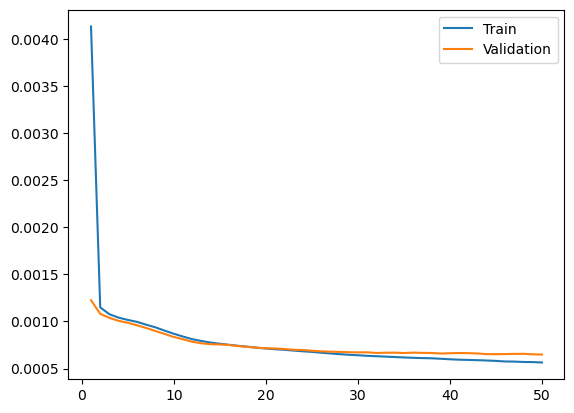

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet_3()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
nepochs = 50
model.to(device)
loss_train = np.zeros(nepochs)
loss_val = np.zeros(nepochs)
for epoch in range(nepochs):
    losses_train = 0
    losses_val = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_y_pred = model(batch_x)
        l = loss(batch_y_pred,batch_y)
        losses_train += l.item()
        l.backward()
        optimizer.step()
    loss_train[epoch] = losses_train / len(train_loader)
    with torch.no_grad():
        for batch_x,batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_pred = model(batch_x)
            l = loss(batch_y_pred,batch_y)
            losses_val += l.item()
    print(f'Train loss at epoch {epoch} : {losses_train/len(train_loader)}' + f',  Val loss at epoch {epoch} : {losses_val/len(val_loader)}')
    loss_val[epoch] = losses_val / len(val_loader)
plt.figure()
plt.plot(np.arange(1,nepochs+1),loss_train,label = 'Train')
plt.plot(np.arange(1,nepochs+1),loss_val,label = 'Validation')
plt.legend()
plt.show()

        


In [27]:
# Sauvegarder les poids
torch.save(model.state_dict(), "./Models/model_Unet_3.pth")

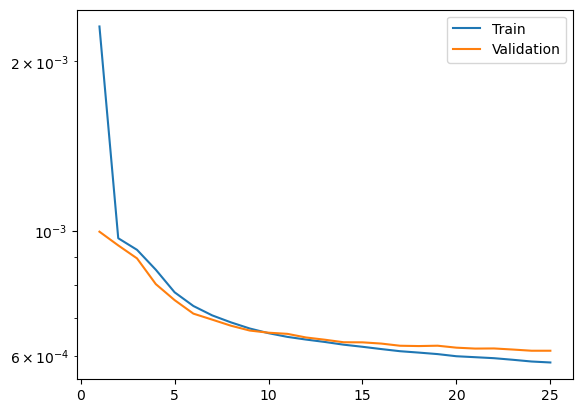

In [207]:
plt.figure()
plt.semilogy(np.arange(1,nepochs+1),loss_train,label = 'Train')
plt.semilogy(np.arange(1,nepochs+1),loss_val,label = 'Validation')
plt.legend()
plt.show()

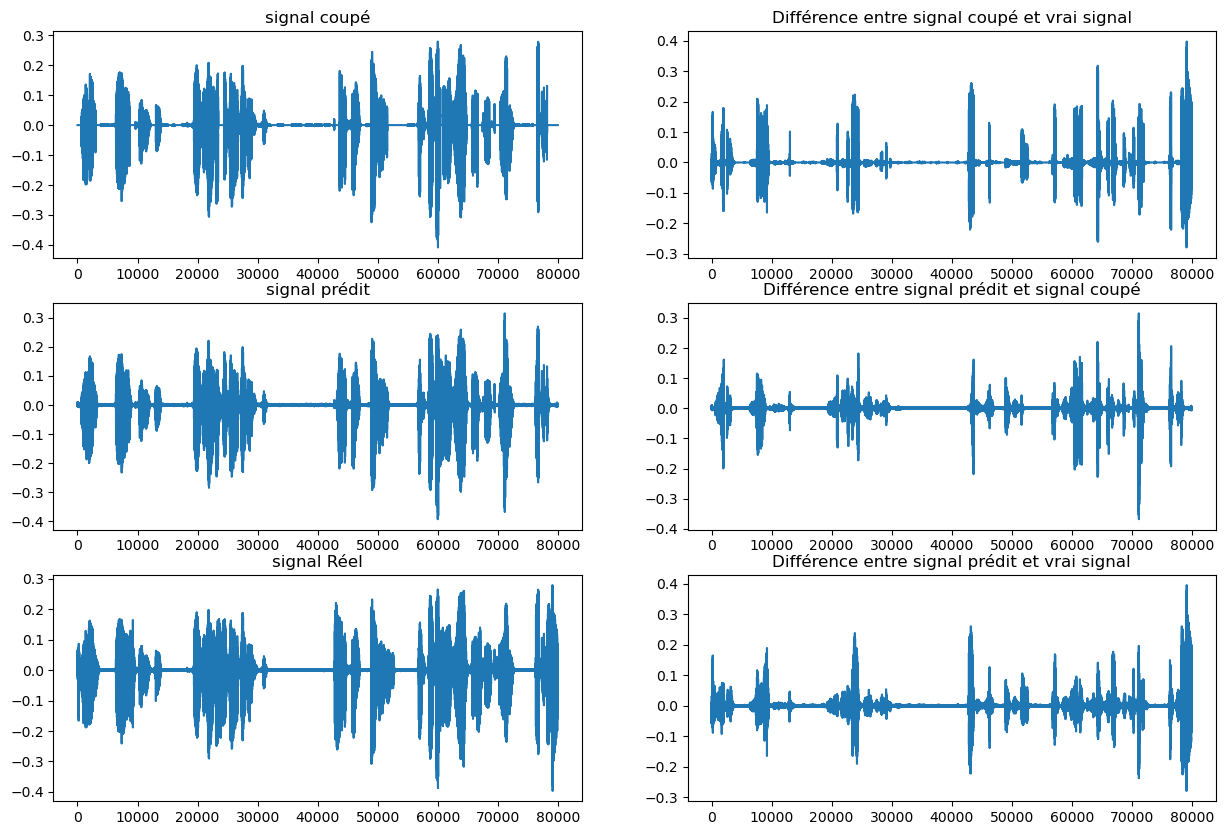

Erreur au carré pour signal coupé 69.4 et pour signal prédit 47.1 


In [47]:
i=3
with torch.no_grad():
    predictions = model(torch.unsqueeze(torch.tensor(signals_train[i]),dim=0).to(device))
    array_predictions = predictions.cpu().numpy()
fig , ax = plt.subplots(figsize=(15,10),nrows =3,ncols = 2)
ax[0,0].plot(signals_train[i])
ax[0,0].set_title('signal coupé')
ax[1,0].plot(array_predictions[0])
ax[1,0].set_title('signal prédit')
ax[2,0].plot(signals_train_label[i])
ax[2,0].set_title('signal Réel')
ax[0,1].plot(signals_train[i]-signals_train_label[i])
ax[0,1].set_title('Différence entre signal coupé et vrai signal')
ax[1,1].plot(array_predictions[0]-signals_train[i])
ax[1,1].set_title('Différence entre signal prédit et signal coupé')
ax[2,1].plot(array_predictions[0]-signals_train_label[i])
ax[2,1].set_title('Différence entre signal prédit et vrai signal')
plt.show()
print(f'Erreur au carré pour signal coupé {(np.sum((signals_train[i]-signals_train_label[i])**2)*100)//10 /10} et pour signal prédit {(np.sum((array_predictions[0]-signals_train_label[i])**2)*100)//10 /10} ')

In [48]:
print(np.sum((array_predictions[0]-signals_train_label[i])**2))
print(np.sum((signals_train[i]-signals_train_label[i])**2))


47.198006
69.42914


In [49]:
with torch.no_grad():
    SE_model = np.zeros(len(signals_train))
    SE_hole = np.zeros(len(signals_train))
    for i in range(len(signals_train)):
        predictions = model(torch.unsqueeze(torch.tensor(signals_train[i]),dim=0).to(device))
        array_predictions = predictions.cpu().numpy()

        SE_model[i] = np.sum((array_predictions[0]-signals_train_label[i])**2)
        SE_hole[i]= np.sum((signals_train[i]-signals_train_label[i])**2)

In [50]:
print(np.mean(SE_model))
print(np.mean(SE_hole))

47.06150371292158
68.10336450364254


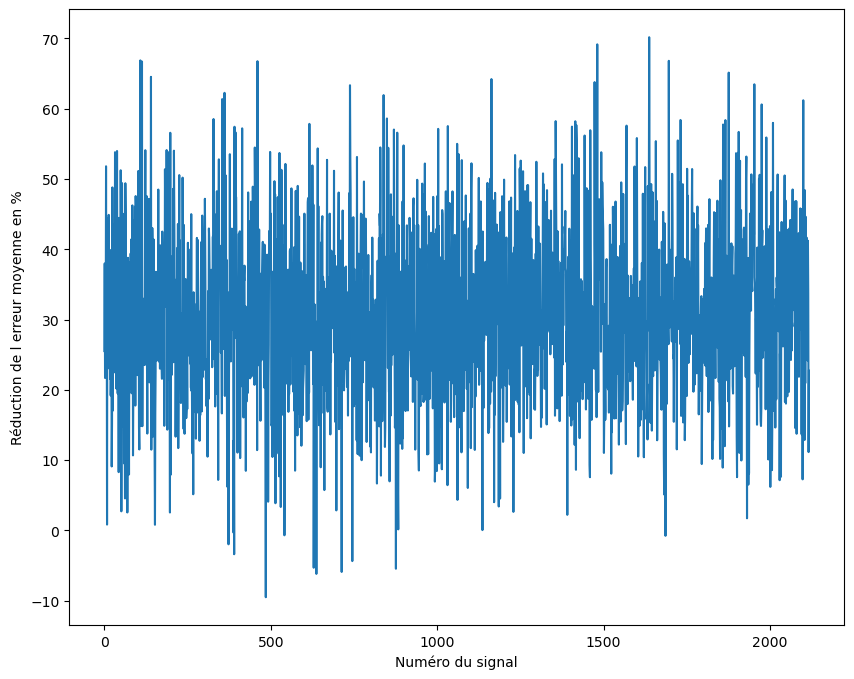

In [53]:
plt.figure(figsize = (10,8))
plt.plot(((SE_hole - SE_model)/SE_hole) * 100)
plt.xlabel('Numéro du signal')
plt.ylabel('Réduction de l erreur moyenne en %')
plt.show()

# Test Encodeur et décodeur

In [113]:
class UNet_Enc(nn.Module):
    def __init__(self):
        super(UNet_Enc, self).__init__()
        # Encoder
        self.enc1 = self.encoder_block(1, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        #self.enc4 = self.encoder_block(256, 512)
        
     

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d( in_channels ,  out_channels, kernel_size=11, padding=4,stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )



    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        return enc3

class UNet_Dec(nn.Module):
    def __init__(self):
        super(UNet_Dec, self).__init__()
        self.dec3 = self.decoder_block(256, 128)
        self.dec2 = self.decoder_block(128, 64)
        self.dec1 = nn.ConvTranspose1d(64, 1, kernel_size=10, stride=8,padding=1)


    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.ConvTranspose1d(out_channels, out_channels, kernel_size=10, stride = 8,padding=1)
        )

    def forward(self, x):

        dec3 = self.dec3(x)
        dec2 = self.dec2(dec3 )
        dec1 = self.dec1(dec2 )

        return dec1

In [114]:
model_enc = UNet_Enc()
model_dec = UNet_Dec()

In [282]:
model_enc = nn.Sequential(
            nn.Conv1d( 1 ,  16, kernel_size=11, padding=4,stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )#80000 --> 10000
model_dec = nn.Sequential(
            nn.Conv1d(16, 1, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(1, 1, kernel_size=8, stride = 8,padding=0)
)#10000 --> 80000
model_enc_1 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=11, padding=1,stride=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec_1 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size=14, stride=6,padding=0)
        )
model_enc_2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=11, padding=1,stride=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec_2 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, kernel_size=14, stride=6,padding=0)
        )

In [129]:
test_enc_dec = torch.unsqueeze(torch.tensor(np.array([signals_train[0],signals_train[1]])),dim=1)

In [283]:
output_enc = model_enc(test_enc_dec)
print(test_enc_dec.shape)
print(output_enc.shape)
output_enc = model_enc_1(output_enc)
print(output_enc.shape)
output_enc = model_enc_2(output_enc)
print(output_enc.shape)

torch.Size([2, 1, 80000])
torch.Size([2, 16, 10000])
torch.Size([2, 32, 1665])
torch.Size([2, 64, 276])


In [284]:
output = model_dec_2(output_enc)
print(output.shape)
output = model_dec_1(output)
print(output.shape)
output = model_dec(output)
print(output.shape)

torch.Size([2, 32, 1664])
torch.Size([2, 16, 9992])


RuntimeError: Given transposed=1, weight of size [1, 1, 8], expected input[2, 16, 9992] to have 1 channels, but got 16 channels instead

In [288]:
model_enc = nn.Sequential(
            nn.Conv1d( 1 ,  16, kernel_size=11, padding=4,stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec = nn.Sequential(
            nn.Conv1d(16, 1, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(1, 1, kernel_size=8, stride = 8,padding=0)
)
model_dec = nn.ConvTranspose1d(16, 1, kernel_size=8, stride = 8,padding=0)
model_enc_1 = nn.Sequential(
            nn.Conv1d( 16 ,  32, kernel_size=9, padding=4,stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec_1 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size=4, stride = 4,padding=0)
)

model_enc_2 = nn.Sequential(
            nn.Conv1d( 32 ,  64, kernel_size=9, padding=4,stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec_2 = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, kernel_size=4, stride = 4,padding=0)
)
model_enc_3 = nn.Sequential(
            nn.Conv1d( 64,  128, kernel_size=11, padding=2,stride=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
model_dec_3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=9, padding=4),#309
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride = 2,padding=0)
)


In [261]:
2500/4

625.0

In [286]:
output_enc = model_enc(test_enc_dec)
print(test_enc_dec.shape)
print(output_enc.shape)
output_enc = model_enc_1(output_enc)
print(output_enc.shape)
output_enc = model_enc_2(output_enc)
print(output_enc.shape)
output_enc = model_enc_3(output_enc)
print(output_enc.shape)

torch.Size([2, 1, 80000])
torch.Size([2, 16, 10000])
torch.Size([2, 32, 2500])
torch.Size([2, 64, 625])
torch.Size([2, 128, 309])


In [289]:
print(output_enc.shape)
output = model_dec_3(output_enc)
print(output.shape)
output = model_dec_2(output)
print(output.shape)
output = model_dec_1(output)
print(output.shape)
output = model_dec(output)
print(output.shape)

torch.Size([2, 128, 309])
torch.Size([2, 64, 625])
torch.Size([2, 32, 2500])
torch.Size([2, 16, 10000])
torch.Size([2, 1, 80000])


# Fin

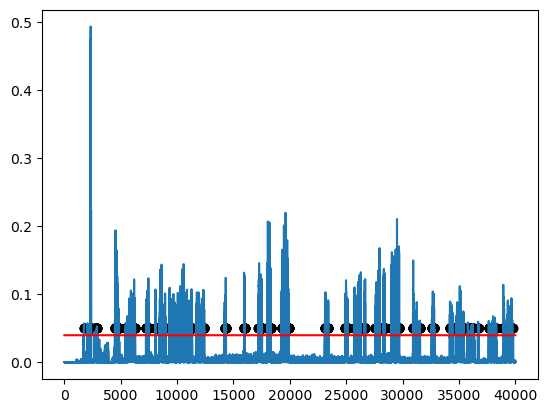

In [8]:
epsilon = 0.04
plt.figure()
plt.plot(np.arange(len(data_orig_norm)),[np.abs(data_orig_norm[i]-data_loss[2*i]) for i in range(len(data_orig_norm))])
plt.plot(np.arange(len(data_orig_norm)),epsilon*np.ones(len(data_orig_norm)),color = 'red')
plt.scatter(argloss,0.05*np.ones_like(argloss),color = 'black')

In [ ]:
loss_interval = []
for i,value in enumerate(argloss):
    h = value
    j=i
    while argloss[j]==h:
        j+=1
        h+=1
    loss_interval

In [80]:
loss_interval = []
value = 0
while value < len(data_orig_norm) and i<len(argloss):
    h = value
    j=i
    while argloss[j]==h:
        j+=1
        h+=1
    loss_interval.append(np.arange(value,h))
    value = h
    j=i

In [83]:
print(len(argloss))

4231


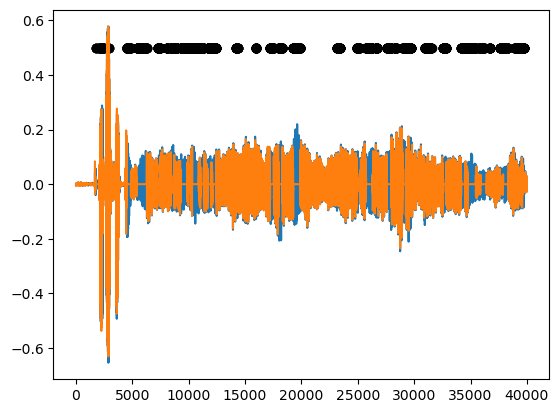

In [72]:
plt.figure()
plt.plot(np.arange(len(data_orig_norm)),data_orig_norm)
plt.plot(np.arange(len(data_loss))/2,data_loss)
plt.scatter(argloss,0.5*np.ones_like(argloss),color = 'black')

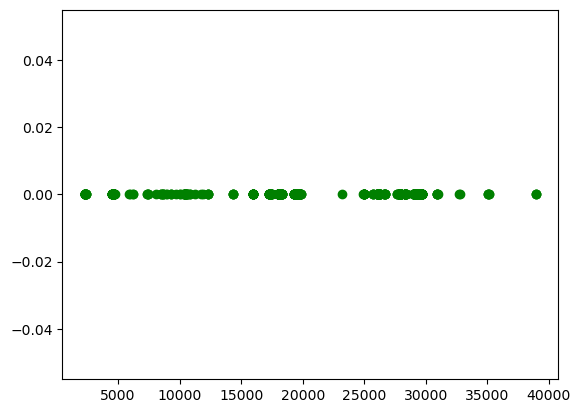

In [54]:
plt.scatter(argloss,np.zeros_like(argloss),color = 'g')

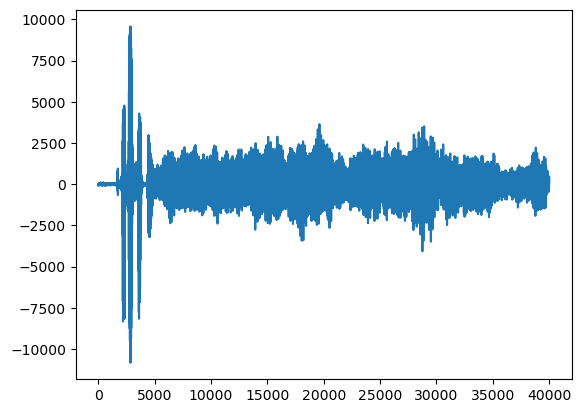

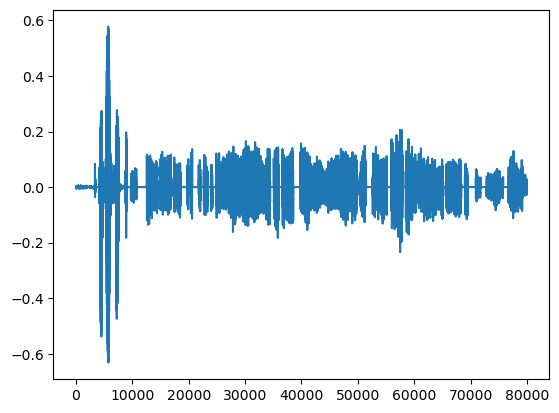

In [21]:
plt.figure()
plt.plot(data_original)
plt.show()
plt.figure()
plt.plot(data_loss)

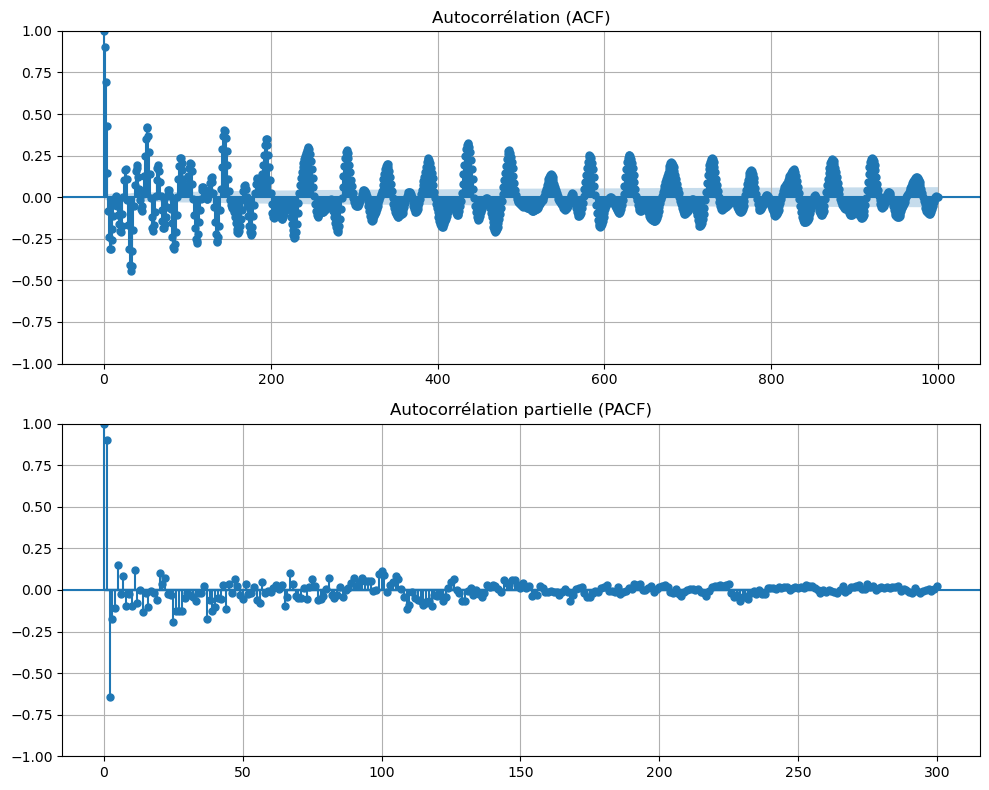

In [25]:

# Tracer l'autocorrélation et l'autocorrélation partielle
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF
plot_acf(data_orig_norm, lags= 1000, ax=axes[0], title="Autocorrélation (ACF)")
axes[0].grid()

# PACF
plot_pacf(data_orig_norm, lags=300, ax=axes[1], method='ywm', title="Autocorrélation partielle (PACF)")
axes[1].grid()

plt.tight_layout()
plt.show()
